<h1> </h1> 
<h1 align=center><font size = 5>Recipe Origin Predictor</font></h1>

## Introduction

In this notebook, I will build a model which predicts the country of origin of a recipe on the basis of the ingredients used in it.

------------

## Table of Contents


1. [About the Data](#0)<br>
2. [Preprocessing](#1)<br>
3. [Data Modeling](#2)<br>
4. [Model Evaluation](#4)<br>

<hr>

# About the data <a id="0"></a>


The data was compiled by a researcher named Yong-Yeol Ahn, who scraped tens of thousands of food recipes (cuisines and ingredients) from three different websites, namely:

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DS0103EN/labs/images/lab4_fig1_allrecipes.png" width=500>

www.allrecipes.com

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DS0103EN/labs/images/lab4_fig2_epicurious.png" width=500>

www.epicurious.com

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DS0103EN/labs/images/lab4_fig3_menupan.png" width=500>

www.menupan.com

For more information on Yong-Yeol Ahn and his research, his research is summarised in [Flavor Network and the Principles of Food Pairing](http://yongyeol.com/papers/ahn-flavornet-2011.pdf).

Downloading the library and dependencies required - 

In [1]:
import pandas as pd 
pd.set_option("display.max_columns", None)
import numpy as np 
import re 
import random 

Downloading the data

In [2]:
recipes = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DS0103EN/labs/data/recipes.csv")

print("Data read into dataframe.") # takes about 30 seconds

Data read into dataframe.


## Preprocessing 

In [3]:
# fixing name of the column displaying the cuisine
column_names = recipes.columns.values
column_names[0] = "cuisine"
recipes.columns = column_names

In [4]:
# converting cuisine names to lower case
recipes["cuisine"] = recipes["cuisine"].str.lower()

In [5]:
# making the cuisine names consistent
recipes.loc[recipes["cuisine"] == "austria", "cuisine"] = "austrian"
recipes.loc[recipes["cuisine"] == "belgium", "cuisine"] = "belgian"
recipes.loc[recipes["cuisine"] == "china", "cuisine"] = "chinese"
recipes.loc[recipes["cuisine"] == "canada", "cuisine"] = "canadian"
recipes.loc[recipes["cuisine"] == "netherlands", "cuisine"] = "dutch"
recipes.loc[recipes["cuisine"] == "france", "cuisine"] = "french"
recipes.loc[recipes["cuisine"] == "germany", "cuisine"] = "german"
recipes.loc[recipes["cuisine"] == "india", "cuisine"] = "indian"
recipes.loc[recipes["cuisine"] == "indonesia", "cuisine"] = "indonesian"
recipes.loc[recipes["cuisine"] == "iran", "cuisine"] = "iranian"
recipes.loc[recipes["cuisine"] == "italy", "cuisine"] = "italian"
recipes.loc[recipes["cuisine"] == "japan", "cuisine"] = "japanese"
recipes.loc[recipes["cuisine"] == "israel", "cuisine"] = "jewish"
recipes.loc[recipes["cuisine"] == "korea", "cuisine"] = "korean"
recipes.loc[recipes["cuisine"] == "lebanon", "cuisine"] = "lebanese"
recipes.loc[recipes["cuisine"] == "malaysia", "cuisine"] = "malaysian"
recipes.loc[recipes["cuisine"] == "mexico", "cuisine"] = "mexican"
recipes.loc[recipes["cuisine"] == "pakistan", "cuisine"] = "pakistani"
recipes.loc[recipes["cuisine"] == "philippines", "cuisine"] = "philippine"
recipes.loc[recipes["cuisine"] == "scandinavia", "cuisine"] = "scandinavian"
recipes.loc[recipes["cuisine"] == "spain", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "portugal", "cuisine"] = "spanish_portuguese"
recipes.loc[recipes["cuisine"] == "switzerland", "cuisine"] = "swiss"
recipes.loc[recipes["cuisine"] == "thailand", "cuisine"] = "thai"
recipes.loc[recipes["cuisine"] == "turkey", "cuisine"] = "turkish"
recipes.loc[recipes["cuisine"] == "vietnam", "cuisine"] = "vietnamese"
recipes.loc[recipes["cuisine"] == "uk-and-ireland", "cuisine"] = "uk-and-irish"
recipes.loc[recipes["cuisine"] == "irish", "cuisine"] = "uk-and-irish"

In [6]:
# removing data for cuisines with < 50 recipes:
recipes_counts = recipes["cuisine"].value_counts()
cuisines_indices = recipes_counts > 50

cuisines_to_keep = list(np.array(recipes_counts.index.values)[np.array(cuisines_indices)])
recipes = recipes.loc[recipes["cuisine"].isin(cuisines_to_keep)]

In [7]:
# converting all Yes's to 1's and the No's to 0's
recipes = recipes.replace(to_replace="Yes", value=1)
recipes = recipes.replace(to_replace="No", value=0)

<hr>

# Data Modeling <a id="2"></a>

Downloading and installing more libraries and dependies to build decision trees.

In [8]:
# importing decision trees scikit-learn libraries
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

!conda install python-graphviz --yes
import graphviz

from sklearn.tree import export_graphviz

import itertools

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



Checking the data again - 

In [9]:
recipes.head()

,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,asparagus,avocado,bacon,baked_potato,balm,banana,barley,bartlett_pear,basil,bay,bean,beech,beef,beef_broth,beef_liver,beer,beet,bell_pepper,bergamot,berry,bitter_orange,black_bean,black_currant,black_mustard_seed_oil,black_pepper,black_raspberry,black_sesame_seed,black_tea,blackberry,blackberry_brandy,blue_cheese,blueberry,bone_oil,bourbon_whiskey,brandy,brassica,bread,broccoli,brown_rice,brussels_sprout,buckwheat,butter,buttermilk,cabbage,cabernet_sauvignon_wine,cacao,camembert_cheese,cane_molasses,caraway,cardamom,carnation,carob,carrot,cashew,cassava,catfish,cauliflower,caviar,cayenne,celery,celery_oil,cereal,chamomile,champagne_wine,chayote,cheddar_cheese,cheese,cherry,cherry_brandy,chervil,chicken,chicken_broth,chicken_liver,chickpea,chicory,chinese_cabbage,chive,cider,cilantro,cinnamon,citrus,citrus_peel,clam,clove,cocoa,coconut,coconut_oil,cod,coffee,cognac,concord_grape,condiment,coriander,corn,corn_flake,corn_grit,cottage_cheese,crab,cranberry,cream,cream_cheese,cucumber,cumin,cured_pork,currant,date,dill,durian,eel,egg,egg_noodle,elderberry,emmental_cheese,endive,enokidake,fennel,fenugreek,feta_cheese,fig,fish,flower,frankfurter,fruit,galanga,gardenia,garlic,gelatin,geranium,gin,ginger,goat_cheese,grape,grape_brandy,grape_juice,grapefruit,green_bell_pepper,green_tea,gruyere_cheese,guava,haddock,ham,hazelnut,herring,holy_basil,honey,hop,horseradish,huckleberry,jamaican_rum,japanese_plum,jasmine,jasmine_tea,juniper_berry,kaffir_lime,kale,katsuobushi,kelp,kidney_bean,kiwi,kohlrabi,kumquat,lamb,lard,laurel,lavender,leaf,leek,lemon,lemon_juice,lemon_peel,lemongrass,lentil,lettuce,licorice,lilac_flower_oil,lima_bean,lime,lime_juice,lime_peel_oil,lingonberry,litchi,liver,lobster,long_pepper,lovage,macadamia_nut,macaroni,mace,mackerel,malt,mandarin,mandarin_peel,mango,maple_syrup,marjoram,mate,matsutake,meat,melon,milk,milk_fat,mint,mozzarella_cheese,mung_bean,munster_cheese,muscat_grape,mushroom,mussel,mustard,mutton,nectarine,nira,nut,nutmeg,oat,oatmeal,octopus,okra,olive,olive_oil,onion,orange,orange_flower,orange_juice,orange_peel,oregano,ouzo,oyster,palm,papaya,parmesan_cheese,parsley,parsnip,passion_fruit,pea,peach,peanut,peanut_butter,peanut_oil,pear,pear_brandy,pecan,pelargonium,pepper,peppermint,peppermint_oil,pimenta,pimento,pineapple,pistachio,plum,popcorn,porcini,pork,pork_liver,pork_sausage,port_wine,potato,potato_chip,prawn,prickly_pear,provolone_cheese,pumpkin,quince,radish,raisin,rapeseed,raspberry,raw_beef,red_algae,red_bean,red_kidney_bean,red_wine,rhubarb,rice,roasted_almond,roasted_beef,roasted_hazelnut,roasted_meat,roasted_nut,roasted_peanut,roasted_pecan,roasted_pork,roasted_sesame_seed,romano_cheese,root,roquefort_cheese,rose,rosemary,rum,rutabaga,rye_bread,rye_flour,saffron,sage,sake,salmon,salmon_roe,sassafras,sauerkraut,savory,scallion,scallop,sea_algae,seaweed,seed,sesame_oil,sesame_seed,shallot,sheep_cheese,shellfish,sherry,shiitake,shrimp,smoke,smoked_fish,smoked_salmon,smoked_sausage,sour_cherry,sour_milk,soy_sauce,soybean,soybean_oil,spearmint,squash,squid,star_anise,starch,strawberry,strawberry_jam,strawberry_juice,sturgeon_caviar,sumac,sunflower_oil,sweet_potato,swiss_cheese,tabasco_pepper,tamarind,tangerine,tarragon,tea,tequila,thai_pepper,thyme,tomato,tomato_juice,truffle,tuna,turkey,turmeric,turnip,vanilla,veal,vegetable,vegetable_oil,vinegar,violet,walnut,wasabi,watercress,watermelon,wheat,wheat_bread,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,vietnamese,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

## [bamboo_tree] Only Asian and Indian Cuisines

Here, we are creating a decision tree for the recipes for just some of the Asian (Korean, Japanese, Chinese, Thai) and Indian cuisines. The reason for this is because the decision tree does not run well when the data is biased towards one cuisine, in this case American cuisines. One option is to exclude the American cuisines from our analysis or just build decision trees for different subsets of the data. Let's go with the latter solution.

Let's build our decision tree using the data pertaining to the Asian and Indian cuisines and name our decision tree *bamboo_tree*.

In [10]:
# select subset of cuisines
asian_indian_recipes = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]
cuisines = asian_indian_recipes["cuisine"]
ingredients = asian_indian_recipes.iloc[:,1:]

bamboo_tree = tree.DecisionTreeClassifier(max_depth=3)
bamboo_tree.fit(ingredients, cuisines)

print("Decision tree model saved to bamboo_tree!")

Decision tree model saved to bamboo_tree!


Let's plot the decision tree and examine how it looks like.

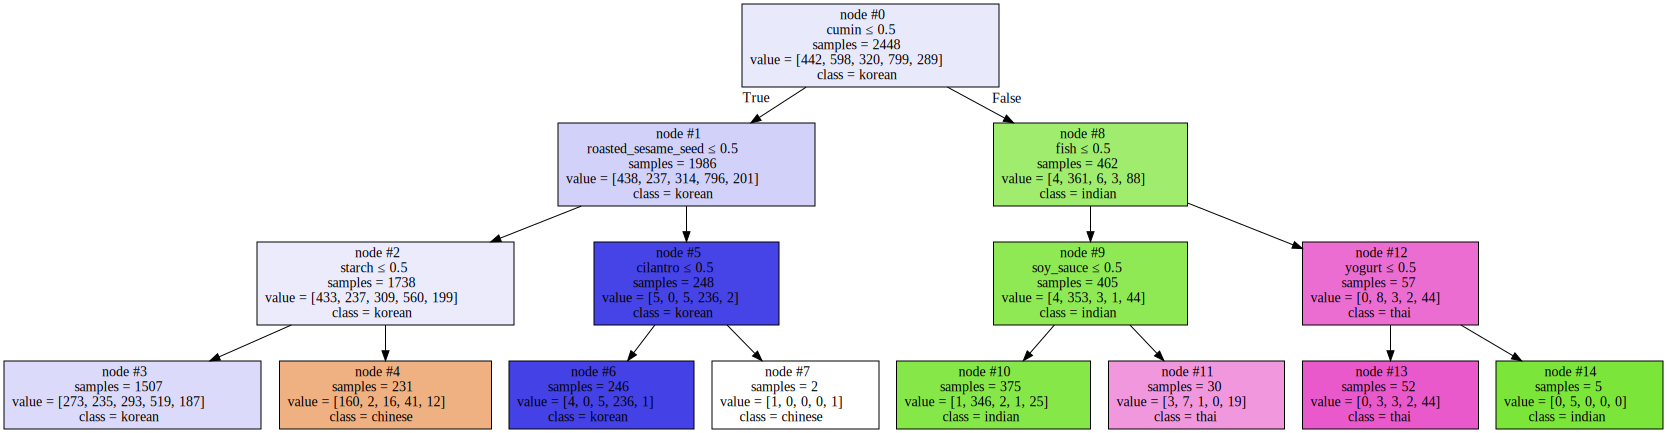

In [11]:
export_graphviz(bamboo_tree,
                feature_names=list(ingredients.columns.values),
                out_file="bamboo_tree.dot",
                class_names=np.unique(cuisines),
                filled=True,
                node_ids=True,
                special_characters=True,
                impurity=False,
                label="all",
                leaves_parallel=False)

with open("bamboo_tree.dot") as bamboo_tree_image:
    bamboo_tree_graph = bamboo_tree_image.read()
graphviz.Source(bamboo_tree_graph)

The decision tree learned:
* If a recipe contains *cumin* and *fish* and **no** *yoghurt*, then it is most likely a **Thai** recipe.
* If a recipe contains *cumin* but **no** *fish* and **no** *soy_sauce*, then it is most likely an **Indian** recipe.

# Model Evaluation <a id="4"></a>

To evaluate our model of Asian and Indian cuisines, the dataset will be split into a training set and a test set. The decision tree will be built using the training set. Then, it will be tested on the test set.

Let's first create a new dataframe using only the data pertaining to the Asian and the Indian cuisines, and let's call the new dataframe **bamboo**.

In [12]:
bamboo = recipes[recipes.cuisine.isin(["korean", "japanese", "chinese", "thai", "indian"])]

Let's see how many recipes exist for each cuisine.

In [13]:
bamboo["cuisine"].value_counts()

korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64

Let's remove 30 recipes from each cuisine to use as the test set, and let's name this test set **bamboo_test**.

In [14]:
# set sample size
sample_n = 30

Create a dataframe containing 30 recipes from each cuisine, selected randomly.

In [15]:
# take 30 recipes from each cuisine
random.seed(1234) # set random seed
bamboo_test = bamboo.groupby("cuisine", group_keys=False).apply(lambda x: x.sample(sample_n))

bamboo_test_ingredients = bamboo_test.iloc[:,1:] # ingredients
bamboo_test_cuisines = bamboo_test["cuisine"] # corresponding cuisines or labels

Check that there are 30 recipes for each cuisine.

In [16]:
# check that we have 30 recipes from each cuisine
bamboo_test["cuisine"].value_counts()

thai        30
chinese     30
indian      30
japanese    30
korean      30
Name: cuisine, dtype: int64

Next, let's create the training set by removing the test set from the **bamboo** dataset, and let's call the training set **bamboo_train**.

In [17]:
bamboo_test_index = bamboo.index.isin(bamboo_test.index)
bamboo_train = bamboo[~bamboo_test_index]

bamboo_train_ingredients = bamboo_train.iloc[:,1:] # ingredients
bamboo_train_cuisines = bamboo_train["cuisine"] # corresponding cuisines or labels

Check that there are 30 _fewer_ recipes now for each cuisine.

In [18]:
bamboo_train["cuisine"].value_counts()

korean      769
indian      568
chinese     412
japanese    290
thai        259
Name: cuisine, dtype: int64

Let's build the decision tree using the training set, **bamboo_train**, and name the generated tree **bamboo_train_tree** for prediction.

In [19]:
bamboo_train_tree = tree.DecisionTreeClassifier(max_depth=15)
bamboo_train_tree.fit(bamboo_train_ingredients, bamboo_train_cuisines)

print("Decision tree model saved to bamboo_train_tree!")

Decision tree model saved to bamboo_train_tree!


Let's plot the decision tree and explore it.

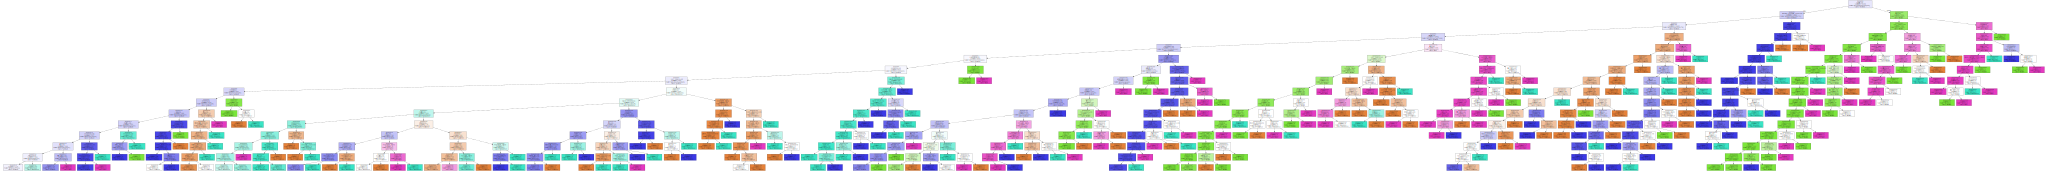

In [20]:
export_graphviz(bamboo_train_tree,
                feature_names=list(bamboo_train_ingredients.columns.values),
                out_file="bamboo_train_tree.dot",
                class_names=np.unique(bamboo_train_cuisines),
                filled=True,
                node_ids=True,
                special_characters=True,
                impurity=False,
                label="all",
                leaves_parallel=False)

with open("bamboo_train_tree.dot") as bamboo_train_tree_image:
    bamboo_train_tree_graph = bamboo_train_tree_image.read()
    
graphviz.Source(bamboo_train_tree_graph)

Now that we defined our tree to be deeper, more decision nodes are generated.

#### Now let's test our model on the test data.

In [21]:
bamboo_pred_cuisines = bamboo_train_tree.predict(bamboo_test_ingredients)

Let's go ahead and create the confusion matrix for how well the decision tree is able to correctly classify the recipes in **bamboo_test**.

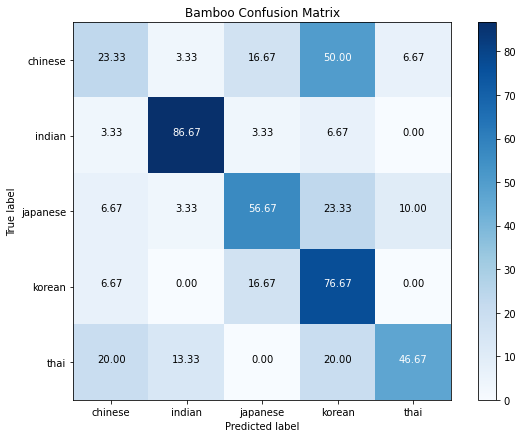

In [22]:
test_cuisines = np.unique(bamboo_test_cuisines)
bamboo_confusion_matrix = confusion_matrix(bamboo_test_cuisines, bamboo_pred_cuisines, test_cuisines)
title = 'Bamboo Confusion Matrix'
cmap = plt.cm.Blues

plt.figure(figsize=(8, 6))
bamboo_confusion_matrix = (
    bamboo_confusion_matrix.astype('float') / bamboo_confusion_matrix.sum(axis=1)[:, np.newaxis]
    ) * 100

plt.imshow(bamboo_confusion_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(test_cuisines))
plt.xticks(tick_marks, test_cuisines)
plt.yticks(tick_marks, test_cuisines)

fmt = '.2f'
thresh = bamboo_confusion_matrix.max() / 2.
for i, j in itertools.product(range(bamboo_confusion_matrix.shape[0]), range(bamboo_confusion_matrix.shape[1])):
    plt.text(j, i, format(bamboo_confusion_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if bamboo_confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

The rows represent the actual cuisines from the dataset and the columns represent the predicted ones. Each row should sum to 100%. According to this confusion matrix, we make the following observations:

* Using the first row in the confusion matrix, 60% of the **Chinese** recipes in **bamboo_test** were correctly classified by our decision tree whereas 37% of the **Chinese** recipes were misclassified as **Korean** and 3% were misclassified as **Indian**.

* Using the Indian row, 77% of the **Indian** recipes in **bamboo_test** were correctly classified by our decision tree and 3% of the **Indian** recipes were misclassified as **Chinese** and 13% were misclassified as **Korean** and 7% were misclassified as **Thai**.

<br>
<hr>